# Import our packages


In [1]:

import zipfile
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn import utils
from yellowbrick.regressor import PredictionError


# Read the CSV
UCI Data was downloaded and put into the git repo. This data was selected from the classifier category under UCI's machine learning dataset website.
## Create a dataframe that can be used throughout our machine learning model


In [2]:
df = pd.read_csv('raw_data.data')
df.columns = ['WIFE_AGE', 'WIFE_ED', 'MAN_ED', 'TOT_KIDS', 'WIFE_ISLAM', 'WIFE_WORK', 'MAN_JOB', 'STD_OF_LIFE', 'MEDIA', 'CONTRACEPTIVE']

   ##Data definition
   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term

### Our data is all about contraceptive use by couples
It primarily includes demographic information for a married couple, with higher emphasis on the female partner.
Let's take a look at some sample data.

In [3]:
print(df.shape)
df.head(10)

(1472, 10)


,WIFE_AGE,WIFE_ED,MAN_ED,TOT_KIDS,WIFE_ISLAM,WIFE_WORK,MAN_JOB,STD_OF_LIFE,MEDIA,CONTRACEPTIVE
0,45,1,3,10,1,1,3,4,0,1
1,43,2,3,7,1,1,3,4,0,1
2,42,3,2,9,1,1,3,3,0,1
3,36,3,3,8,1,1,3,2,0,1
4,19,4,4,0,1,1,3,3,0,1
5,38,2,3,6,1,1,3,2,0,1
6,21,3,3,1,1,0,3,2,0,1
7,27,2,3,3,1,1,3,4,0,1
8,45,1,1,8,1,1,2,2,1,1
9,38,1,3,2,1,0,3,3,1,1


### Let's visualize the data to get a better understanding about the distribution of data
#### Our label is the class for contraceptive use

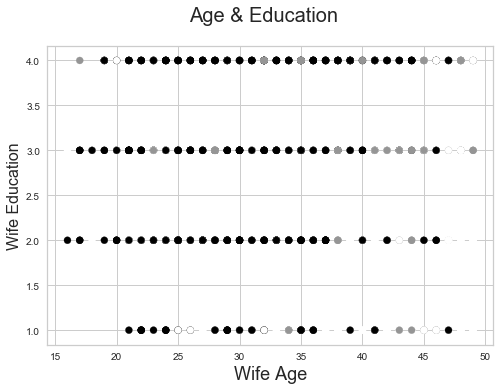

In [4]:
plt.scatter(df.WIFE_AGE, df.WIFE_ED , c=df.CONTRACEPTIVE)
plt.suptitle('Age & Education', fontsize=20)
plt.xlabel('Wife Age', fontsize=18)
plt.ylabel('Wife Education', fontsize=16)
plt.show()

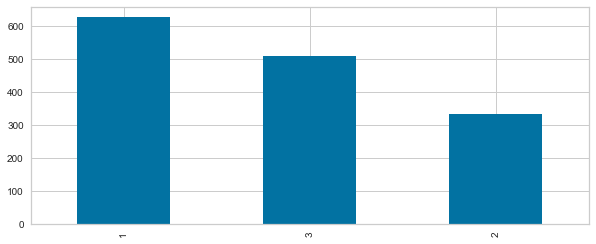

In [5]:
plt.figure(figsize=(10,4))
df["CONTRACEPTIVE"].value_counts().plot(kind='bar')
plt.show()

In [6]:
df.describe()

,WIFE_AGE,WIFE_ED,MAN_ED,TOT_KIDS,WIFE_ISLAM,WIFE_WORK,MAN_JOB,STD_OF_LIFE,MEDIA,CONTRACEPTIVE
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,32.544158,2.959239,3.430027,3.261549,0.850543,0.749321,2.137908,3.133832,0.074049,1.920516
std,8.227027,1.015031,0.816549,2.359341,0.356659,0.433552,0.865144,0.976486,0.261939,0.876345
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,4.250000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


## Heavily Islamic population, mostly educated with both parents working and a good quality of life. 
# NO MAJOR MISSING DATA


In [7]:
corr_matrix = df.corr().abs()
corr_matrix
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print("Here are the features that are highly correlated with each other:")
high_corr_var

Here are the features that are highly correlated with each other:


[]

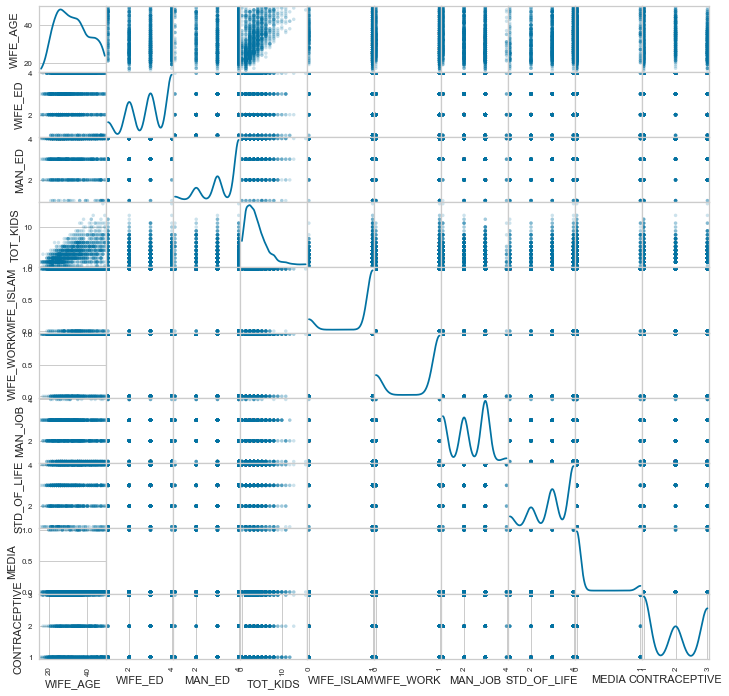

In [8]:
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

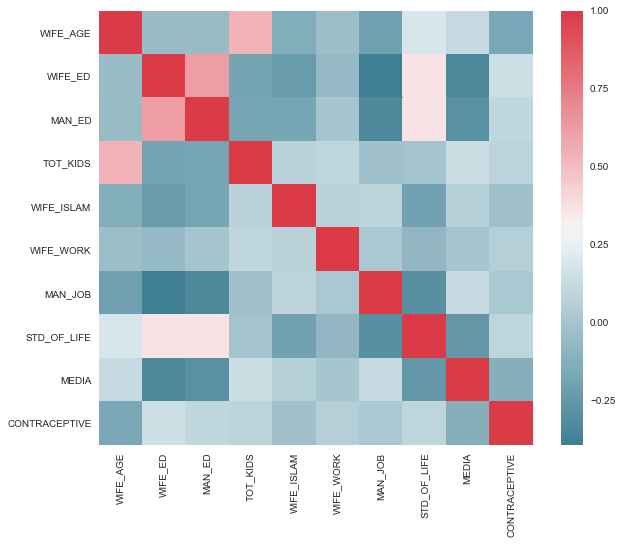

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [10]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df)
df_standardized = pd.DataFrame(train_data,index=train_data[:,0])
df_standardized.columns = ['WIFE_AGE', 'WIFE_ED', 'MAN_ED', 'TOT_KIDS', 'WIFE_ISLAM', 'WIFE_WORK', 'MAN_JOB', 'STD_OF_LIFE', 'MEDIA', 'CONTRACEPTIVE']
df_standardized.describe()

,WIFE_AGE,WIFE_ED,MAN_ED,TOT_KIDS,WIFE_ISLAM,WIFE_WORK,MAN_JOB,STD_OF_LIFE,MEDIA,CONTRACEPTIVE
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,0.501338,0.653080,0.810009,0.203847,0.850543,0.749321,0.379303,0.711277,0.074049,0.460258
std,0.249304,0.338344,0.272183,0.147459,0.356659,0.433552,0.288381,0.325495,0.261939,0.438173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.303030,0.333333,0.666667,0.062500,1.000000,0.000000,0.000000,0.666667,0.000000,0.000000
50%,0.484848,0.666667,1.000000,0.187500,1.000000,1.000000,0.333333,0.666667,0.000000,0.500000
75%,0.696970,1.000000,1.000000,0.265625,1.000000,1.000000,0.666667,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
features = df_standardized.drop(['CONTRACEPTIVE'], axis=1)
labels   = df_standardized['CONTRACEPTIVE']

lab_enc = preprocessing.LabelEncoder()
encoded_labels = lab_enc.fit_transform(labels)

print(utils.multiclass.type_of_target(encoded_labels))




multiclass


In [12]:
## Lasso 
model = Lasso()
model.fit(features, encoded_labels)
print(list(zip(features, model.coef_.tolist())))

[('WIFE_AGE', -0.0), ('WIFE_ED', 0.0), ('MAN_ED', 0.0), ('TOT_KIDS', 0.0), ('WIFE_ISLAM', -0.0), ('WIFE_WORK', 0.0), ('MAN_JOB', 0.0), ('STD_OF_LIFE', 0.0), ('MEDIA', -0.0)]


In [13]:
## Ridge 
model = Ridge()
model.fit(features, encoded_labels)
print(list(zip(features, model.coef_.tolist())))

[('WIFE_AGE', -1.0756571297570368), ('WIFE_ED', 0.3761803292640445), ('MAN_ED', 0.04939899154383048), ('TOT_KIDS', 1.655480122137108), ('WIFE_ISLAM', -0.09338863885155999), ('WIFE_WORK', 0.06738975236485306), ('MAN_JOB', 0.18154243925726948), ('STD_OF_LIFE', 0.24423119619180525), ('MEDIA', -0.1674411499622074)]


In [14]:
model = ElasticNet()
model.fit(features, encoded_labels)
print(list(zip(features, model.coef_.tolist())))

[('WIFE_AGE', -0.0), ('WIFE_ED', 0.0), ('MAN_ED', 0.0), ('TOT_KIDS', 0.0), ('WIFE_ISLAM', -0.0), ('WIFE_WORK', 0.0), ('MAN_JOB', 0.0), ('STD_OF_LIFE', 0.0), ('MEDIA', -0.0)]


In [15]:
# Identify our data and target 
x = features
y = encoded_labels

# Create random train and test splits to avoid bais and overfitting
splits = tts(x, y, test_size=.2)
x_train, x_test, y_train, y_test = splits

x_train.shape

(1177, 9)

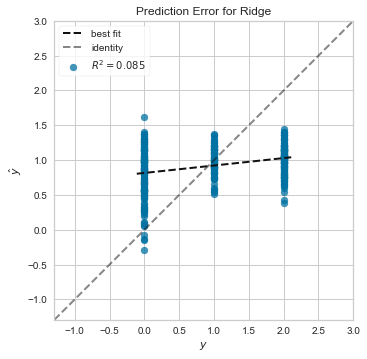

In [16]:
visualizer = PredictionError(Ridge())
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
visualizer.poof()

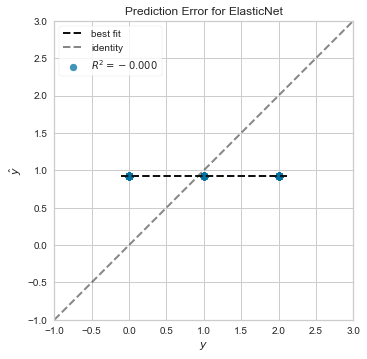

In [17]:
visualizer = PredictionError(ElasticNet())
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
visualizer.poof()

## Yellowbrick Radviz prep work

In [18]:
# Extract the numpy arrays from the data frame
X_radviz = features.as_matrix()
#y = data.occupancy.as_matrix()
feature_names = ['WIFE_AGE', 'WIFE_ED', 'MAN_ED', 'TOT_KIDS', 'WIFE_ISLAM', 'WIFE_WORK', 'MAN_JOB', 'STD_OF_LIFE', 'MEDIA']
label_name   = ['CONTRACEPTIVE']

X_radviz
encoded_labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

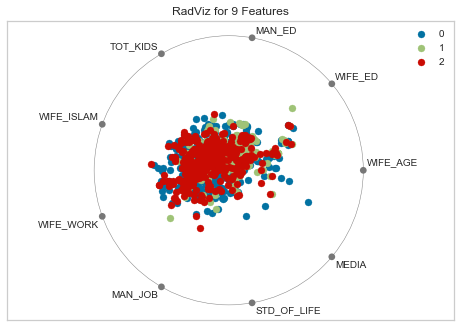

In [19]:
# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer
visualizer = RadViz()

visualizer.fit(x_train,y_train)      # Fit the data to the visualizer
visualizer.transform(x_train)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

### Looks like lots of noise. It's going to be hard to get separation and good predictive results on this classifier problem.

Can we learn more by trying...
### Parallel Coordinates

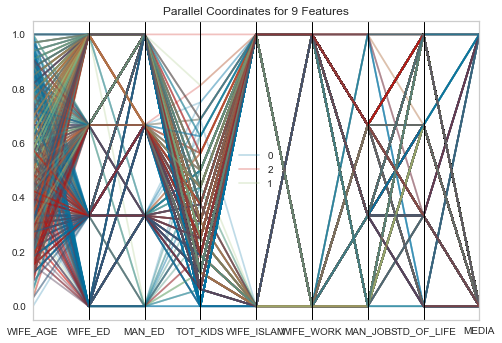

In [20]:
from yellowbrick.features import ParallelCoordinates

# Instantiate the visualizer
visualizer = ParallelCoordinates()

visualizer.fit(x_train, y_train)      # Fit the data to the visualizer
visualizer.transform(x_train)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

That isn't too helpful.. It looks like there are trends in the wife's age, wife's education, as well as the total kids.
This is really showing that we have a lot of noise. This is partially created by the nature of many features being bivariate (dummy) variables..

### Perhaps it is time to eliminate some features..
## Recursive Feature Elimination visual

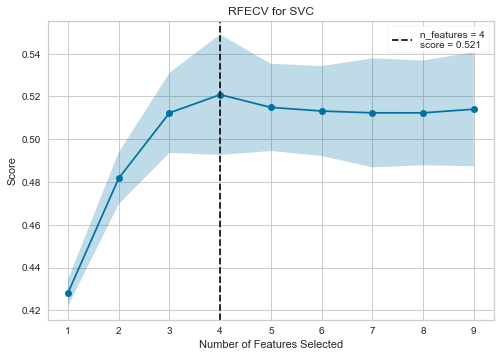

In [21]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification

from yellowbrick.features import RFECV

# Create RFECV visualizer with linear SVM classifier
viz = RFECV(SVC(kernel='linear', C=1))
viz.fit(x_train, y_train)
viz.poof()

### Interesting ...
Our 3 previously identified features seem to give us the most predictive power, but actually, the other features do indeed provide some model maximizing predictive information.

We could either cut our features to 3 total, or go to around 7, 8, or 9
Let's keep them all, because there are so few this time around.

In [22]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [23]:
results=[]
names=[]

def fit_model(model, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(x_train, y_train)
    duration = time.time() - start 
    score = model.score(x_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    #print(model.get_params()) 
    visualizer = ClassificationReport(model)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.poof()
    
    
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    #print(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)

LogisticRegression fit in 0.01 seconds score: 0.5017


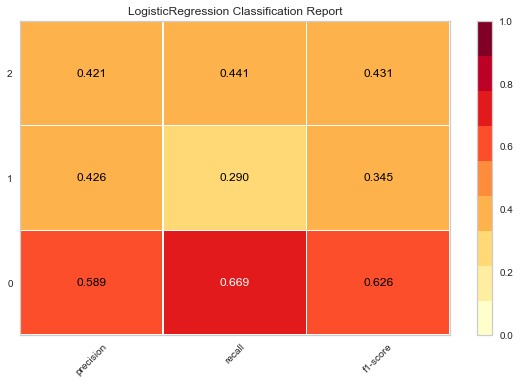

KNeighborsClassifier fit in 0.00 seconds score: 0.5220


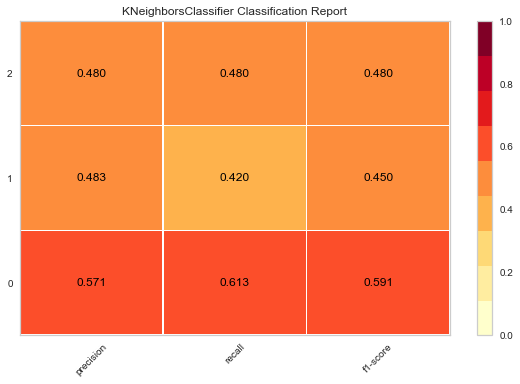

DecisionTreeClassifier fit in 0.00 seconds score: 0.5017


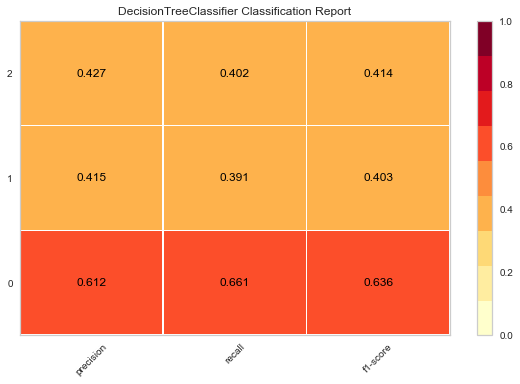

RandomForestClassifier fit in 0.02 seconds score: 0.5051


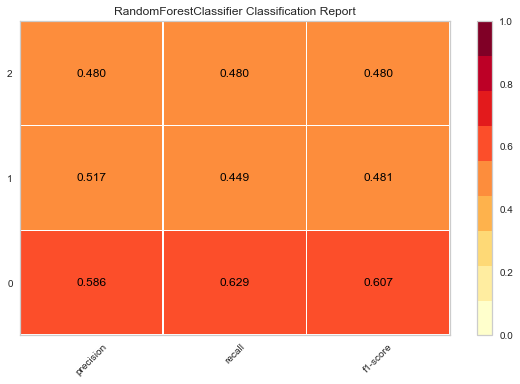

GaussianNB fit in 0.00 seconds score: 0.4746


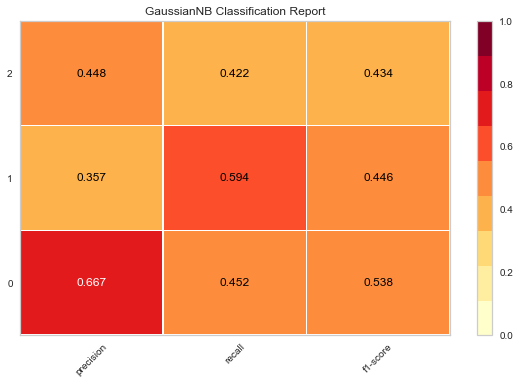

SVC fit in 0.05 seconds score: 0.4881


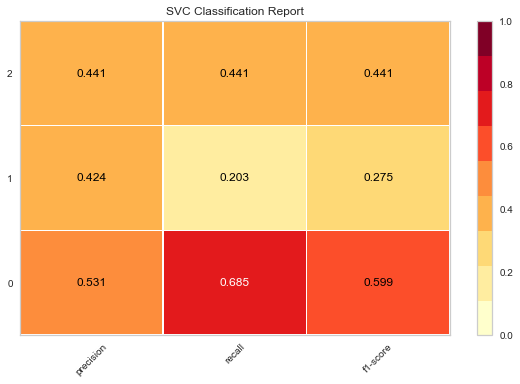

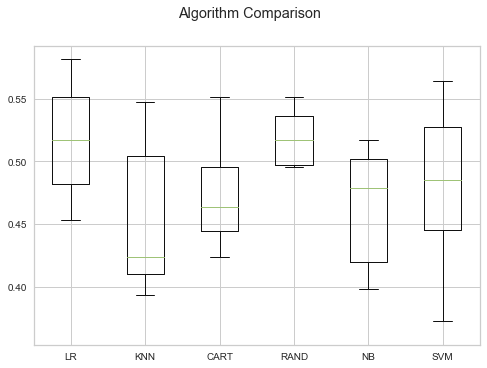

In [24]:
# prepare models


models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RAND', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

    
for name,model in models:
    fit_model(model)    
    
    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## It appears to be much easier to identify the '0' class. That class is the non-contraceptive user class.
The '1' class seems to be much more difficult to identify, generally having lower precision, recall, and an F-1 score. It isn't too surprising that we see these results, given that the Radviz chart showed the '1' class having a lot of overlap with the other classes.


Let's run a numerical example showing the total F-1 score, weighted by the number of instances that are in each category.

In [25]:

y = y_test
def predict_model(model):
    yhat = model.predict(x_test)
    #r2 = r2_score(target_predict, yhat)
    #me = mse(target_predict, yhat)
    #print("r2={:0.3f} MSE={:0.3f}".format(r2,me))
    print(name, model)
    print(classification_report(y, yhat))
    #print(yhat)

    
    
for name, model in models:
    predict_model(model) 

LR LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.59      0.67      0.63       124
          1       0.43      0.29      0.34        69
          2       0.42      0.44      0.43       102

avg / total       0.49      0.50      0.49       295

KNN KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          0       0.57      0.61      0.59       124
          1       0.48      0.42      0.45        69
          2       0.48      0.48      0.48       102

avg / total       0.52      0.52      0.52       295

CART DecisionTreeClassifier(

## It looks like the Cartesian Decision Tree model is giving the best results
It is actually somewhat able to identify both teh '0' class and '2' class.
Let's explore hyperparameter tuning:

In [26]:
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=2, min_samples_leaf=5, max_features=9)
clf.fit(x_train, y_train)
#x_train
score = clf.score(x_test, y_test)
pred_rslt = clf.predict(x_test)

print(classification_report(y_test, pred_rslt))

##print("Predicted:", pred_rslt)
##print("Actual : ", y_test)
print("Top: Predicted, left: Actual")
confusion_matrix(y_test, pred_rslt)

             precision    recall  f1-score   support

          0       0.83      0.44      0.58       124
          1       0.56      0.20      0.30        69
          2       0.43      0.86      0.58       102

avg / total       0.63      0.53      0.51       295

Top: Predicted, left: Actual


array([[55,  3, 66],
       [ 5, 14, 50],
       [ 6,  8, 88]], dtype=int64)

## Note: If you reduce the number of features, the F-1 score drops significantly!
Maybe this is just for this model, but so far, this model has the highest F-1 score.

# Next Steps
1. Gather more data: The number one issue with this classifier is that there aren't enough descriptive features
2. Recalibrate input data: A number of our features have been simplified into just a couple categories (ex. high, med, low). Having more detailed data in some of the existing features may also get better results
3. Rerun model and see if the most accurate model type changes
4. Test hyper parameters to see if you cna refine the model.